In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd

In [10]:
bigp = ['BNP', 'Jamaat', 'NCP']
mainp = ['Jamaat', 'BNP']

In [18]:
# get 2026 election data
df = pd.read_csv('https://raw.githubusercontent.com/muhallilahnaf/election-2026-live/master/data/party_votes_pa.csv')
df.head()

,party,vote,voters,avg_vote_pc,total_vote_pc,count,alliance
0,AB Party,187560,1275015.0,14.71,0.15,NaN,Jamaat-NCP
1,BJP,105543,406567.0,25.96,0.09,1.0,BNP
2,BNP,36453458,115914909.0,31.45,29.75,208.0,BNP
3,Bangladesh Development Party,124249,773191.0,16.07,0.10,NaN,Jamaat-NCP
4,Bangladesh Islami Front,194873,1640640.0,11.88,0.16,NaN,no alliance


In [19]:
df = df[~df['count'].isna()]
df = df.sort_values(by='count', ascending=False)
df.head()

,party,vote,voters,avg_vote_pc,total_vote_pc,count,alliance
2,BNP,36453458,115914909.0,31.45,29.75,208.0,BNP
10,Jamaat,22756998,87224538.0,26.09,18.57,69.0,Jamaat-NCP
8,Independent,2293779,11382757.0,20.15,1.87,7.0,no alliance
14,NCP,2151569,10003140.0,21.51,1.76,6.0,Jamaat-NCP
5,Bangladesh Khelafat Mojlish,1227713,6759929.0,18.16,1.00,2.0,Jamaat-NCP


In [20]:
df = df[['party', 'vote', 'total_vote_pc', 'count']].rename(columns={
    'count': 'seats_fptp',
    'vote': 'votes',
    'total_vote_pc': 'votes_pc'
})
df.head()

,party,votes,votes_pc,seats_fptp
2,BNP,36453458,29.75,208.0
10,Jamaat,22756998,18.57,69.0
8,Independent,2293779,1.87,7.0
14,NCP,2151569,1.76,6.0
5,Bangladesh Khelafat Mojlish,1227713,1.00,2.0


In [21]:
# list all electoral methods
methods = ['fptp', 'pr', 'mmp']


# D'Hondt / Jefferson method
def dhondt(votes, total_seats):
    # initialize seats and quotient
    seats = {party: 0 for party in votes}
    q = {party: 1 for party in votes}
    # loop for each seat
    for _ in range(total_seats):
        # calculate the ratio
        ratios = {party: votes[party] / q[party] for party in votes}
        # find the party with max ratio
        max_ratio_party = max(ratios, key=ratios.get)
        # give 1 seat to party with max ratio
        seats[max_ratio_party] += 1
        # increase quotient by 1 of party with max ratio
        q[max_ratio_party] += 1
    return seats


# Sainte-Laguë / Webster method
def slague(votes, total_seats):
    # initialize seats and quotient
    seats = {party: 0 for party in votes}
    q = {party: 1 for party in votes}
    # loop for each seat
    for _ in range(total_seats):
        # calculate the ratio
        ratios = {party: votes[party] / q[party] for party in votes}
        # find the party with max ratio
        max_ratio_party = max(ratios, key=ratios.get)
        # give 1 seat to party with max ratio
        seats[max_ratio_party] += 1
        # increase quotient by 2 of party with max ratio
        q[max_ratio_party] += 2
    return seats


# Mixed-member proportional (compensation using D'Hondt)
def mmp_dhondt(df, dseat, rseat):
    dfq = df.copy()
    # total = direct + reserved
    tseat = dseat + rseat
    
    # create votes and seats map of each party
    votes = dfq.set_index('party')['votes'].to_dict()
    seats = dfq.set_index('party')['seats_fptp'].to_dict()
    
    # find seats % obtained through direct election (FPTP)
    dfq['seats_fptp_pc'] = round(df[f'seats_fptp'] / dseat * 100, 2)
    
    # find the gap between votes % and seats % of each party
    dfq['seats_pc_diff'] = dfq['votes_pc'] - dfq['seats_fptp_pc']
    # get the data as a party map
    shorts = dfq.set_index('party')['seats_pc_diff'].to_dict()
    
    # remove independent candidates as they don't represent a party
    shorts.pop('Independents', None)
    shorts.pop('Independent', None)
    
    # remove parties that don't need compensation
    for party, diff in list(shorts.items()):
        if diff <= 0:
            del shorts[party]
    
    # initialize quotients for D'Hondt
    q = {party: 1 for party in shorts}
    
    # loop for each reserved seat
    for _ in range(rseat):
        # calculate the ratio
        ratios = {party: votes[party] / q[party] for party in shorts}
        # find the party with max ratio
        max_ratio_party = max(ratios, key=ratios.get)
        # give 1 seat to party with max ratio
        seats[max_ratio_party] += 1
        # increase quotient by 1 of party with max ratio
        q[max_ratio_party] += 1
        
    return seats

# Mixed-member proportional (compensate by directly adding the number of seats a party lacks)
def mmp_mod(df, dseat, rseat):
    dfq = df.copy()
    # total = direct + reserved
    tseat = dseat + rseat
    
    # create votes % and seats map of each party
    votes_pc = dfq.set_index('party')['votes_pc'].to_dict()
    seats = dfq.set_index('party')['seats_fptp'].to_dict()
    
    # calculate the number of seats a party should get using PR
    seats_pr = {party: int(vpc * tseat / 100) for party, vpc in votes_pc.items()}
    # sort in descending order
    seats_pr_sorted = sorted(seats_pr.items(), key=lambda x: x[1], reverse=True)
    
    for party, seat in seats_pr_sorted:
        # skip independent candidates as they don't represent a party
        if party == 'Independents':
            continue
        if party == 'Independent':
            continue 
        short = seat - seats[party]
        # skip parties that don't need compensation
        if short <= 0:
            continue
        # find minimum of seats short and seats available
        extra_seat = min(short, rseat)
        # give the seats to the party
        seats[party] += extra_seat
        # remove the seats from seats available
        rseat -= extra_seat
        # if no seats available, quit
        if rseat <= 0:
            break
            
    return seats

print(dhondt({'A': 40, 'B': 30, 'C': 22, 'D': 8}, 10))
print(slague({'A': 40, 'B': 30, 'C': 22, 'D': 8}, 10))

{'A': 5, 'B': 3, 'C': 2, 'D': 0}
{'A': 4, 'B': 3, 'C': 2, 'D': 1}


In [22]:
# get party - votes map
df_votes = df.set_index('party')['votes'].to_dict()

# apply PR and MMP methods
dh_seats = dhondt(df_votes, 300)
mmp_seats = mmp_dhondt(df, 300, 50)

# add the results to dataframe
df['seats_pr'] = df['party'].map(dh_seats)
df['seats_mmp'] = df['party'].map(mmp_seats)

df.head()

,party,votes,votes_pc,seats_fptp,seats_pr,seats_mmp
2,BNP,36453458,29.75,208.0,168,208.0
10,Jamaat,22756998,18.57,69.0,105,69.0
8,Independent,2293779,1.87,7.0,10,7.0
14,NCP,2151569,1.76,6.0,9,6.0
5,Bangladesh Khelafat Mojlish,1227713,1.00,2.0,5,38.0


In [23]:
# calculate seats % for each method
for method in methods:
    tseat = 300
    if method == 'mmp':
        tseat = 350
    df[f'seats_{method}_pc'] = round(df[f'seats_{method}'] / tseat * 100, 2)
    
df.head()

,party,votes,votes_pc,seats_fptp,seats_pr,seats_mmp,seats_fptp_pc,seats_pr_pc,seats_mmp_pc
2,BNP,36453458,29.75,208.0,168,208.0,69.33,56.00,59.43
10,Jamaat,22756998,18.57,69.0,105,69.0,23.00,35.00,19.71
8,Independent,2293779,1.87,7.0,10,7.0,2.33,3.33,2.00
14,NCP,2151569,1.76,6.0,9,6.0,2.00,3.00,1.71
5,Bangladesh Khelafat Mojlish,1227713,1.00,2.0,5,38.0,0.67,1.67,10.86


In [24]:
year = 2026
df.to_csv(f'dataout/method_big_{year}.csv', index=False)

In [25]:
# filter out winner parties data
df_winner = df[(df['seats_fptp'] + df['seats_pr'] + df['seats_mmp']) >= 1]

# split into big and small parties
df_winner_big = df_winner[df_winner.party.isin(bigp)]
df_winner_small = df_winner[~df_winner.party.isin(bigp)]

In [26]:
# rename plot method labels function
def change_method_labels(labels):
    mlist = methods + ['sl', 'dh']
    new_labels = []
    for label in labels:
        out = label.replace('_', ' ').replace('pc', '%')
        out = out.title()
        for method in mlist:
            out = out.replace(method.title(), method.upper())
        new_labels.append(out)
    return new_labels

# rename plot party labels function
def change_party_labels(labels):
    pdict = {p.lower(): p for p in df.party.to_list()}
    new_labels = []
    for label in labels:
        if label.lower() in pdict:
            new_labels.append(pdict[label.lower()])
    return new_labels

C:\Users\muhal\AppData\Local\Temp\ipykernel_960\242687169.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(change_method_labels(vcols))


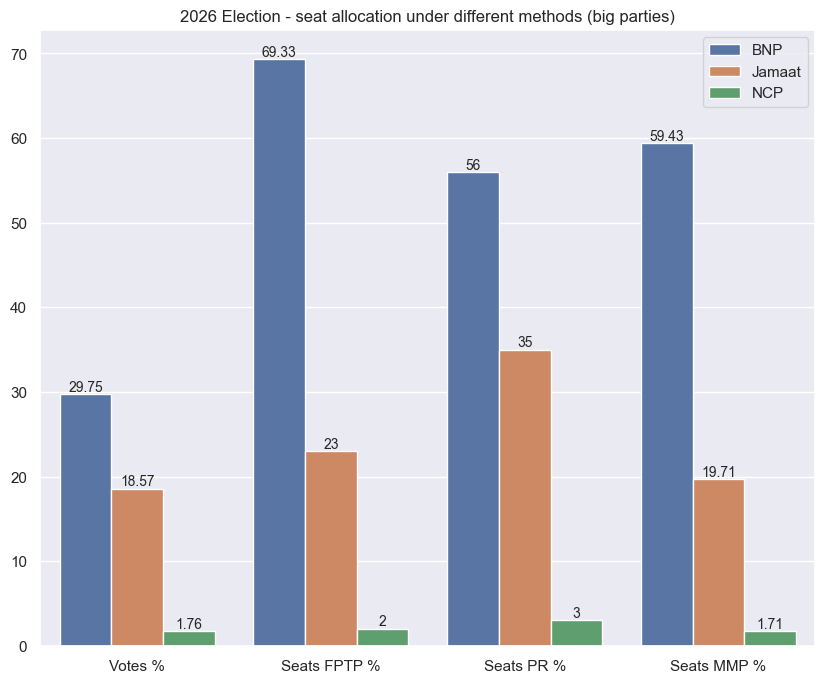

In [27]:
# melt the data for plotting big parties
vcols = ['votes_pc', 'seats_fptp_pc', 'seats_pr_pc', 'seats_mmp_pc']
melted = pd.melt(
    df_winner_big, 
    id_vars='party', 
    value_vars=vcols)

# plot seat allocation for big parties
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=melted, x='variable', y='value', hue='party', ax=ax)

# set xtick labels
ax.set_xticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
    
# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)

# add title
plt.title(f'{year} Election - seat allocation under different methods (big parties)')

plt.show()

# save plot
fig.savefig(f'fig/method_big_{year}',bbox_inches='tight')

C:\Users\muhal\AppData\Local\Temp\ipykernel_960\193628208.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(change_method_labels(vcols))


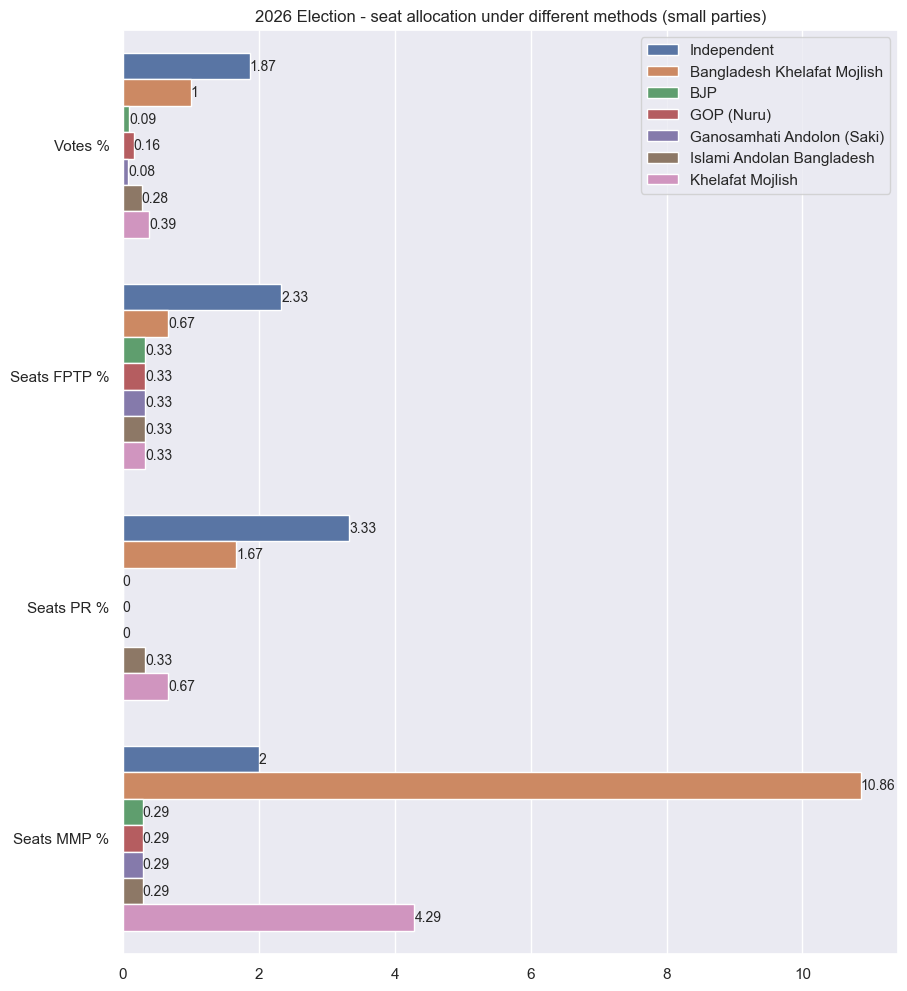

In [28]:
# melt the data for plotting small parties
vcols = ['votes_pc', 'seats_fptp_pc', 'seats_pr_pc', 'seats_mmp_pc']
melted = pd.melt(
    df_winner_small, 
    id_vars='party', 
    value_vars=vcols)

# plot seat allocation for small parties
fig, ax = plt.subplots(figsize=(10, 12))
sns.barplot(data=melted, y='variable', x='value', hue='party', ax=ax)

# set ytick labels
ax.set_yticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)
    
# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)

# add title
plt.title(f'{year} Election - seat allocation under different methods (small parties)')

plt.show()

# save plot
fig.savefig(f'fig/method_small_{year}',bbox_inches='tight')

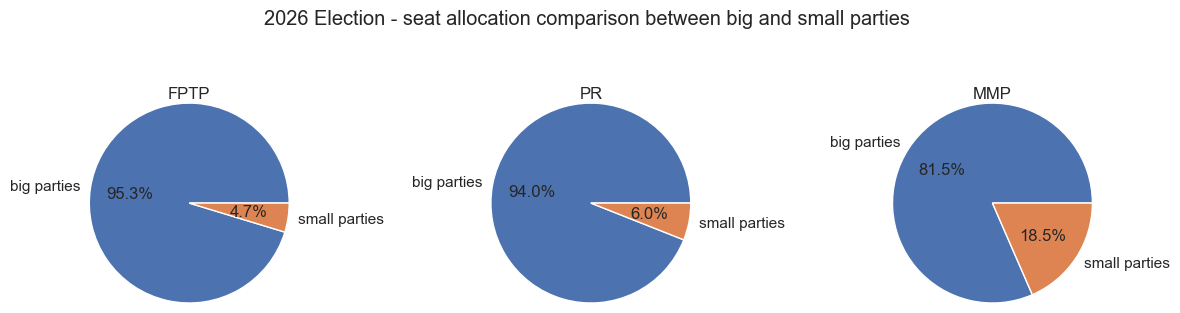

In [29]:
# plot comparison between methods for big and small parties
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, method in enumerate(methods):
    seat_sums = [
        df_winner_big[f'seats_{method}_pc'].sum(),
        df_winner_small[f'seats_{method}_pc'].sum()
    ]
    labels = ['big parties', 'small parties']
    axes[i].pie(seat_sums, labels=labels, autopct='%1.1f%%', radius = 1.3)
    axes[i].set_title(method.upper())
        
fig.tight_layout()
plt.suptitle(f'{year} Election - seat allocation comparison between big and small parties')
fig.savefig(f'fig/method_bigvsmall_{year}',bbox_inches='tight')
plt.show()

In [30]:
# calculate seats using Sainte-Laguë and MMP (modified) methods
sl_seats = slague(df_votes, 300)
mmp_mod_seats = mmp_mod(df, 300, 50)

# add the results to dataframe
df['seats_pr_sl'] = df['party'].map(sl_seats)
df['seats_mmp_mod'] = df['party'].map(mmp_mod_seats)

# calculate seats % for each method
df['seats_pr_sl_pc'] = round(df['seats_pr_sl'] / 300 * 100, 2)
df['seats_mmp_mod_pc'] = round(df['seats_mmp_mod'] / 350 * 100, 2)

df.head()

,party,votes,votes_pc,seats_fptp,seats_pr,seats_mmp,seats_fptp_pc,seats_pr_pc,seats_mmp_pc,seats_pr_sl,seats_mmp_mod,seats_pr_sl_pc,seats_mmp_mod_pc
2,BNP,36453458,29.75,208.0,168,208.0,69.33,56.00,59.43,166,208.0,55.33,59.43
10,Jamaat,22756998,18.57,69.0,105,69.0,23.00,35.00,19.71,103,69.0,34.33,19.71
8,Independent,2293779,1.87,7.0,10,7.0,2.33,3.33,2.00,10,7.0,3.33,2.00
14,NCP,2151569,1.76,6.0,9,6.0,2.00,3.00,1.71,10,6.0,3.33,1.71
5,Bangladesh Khelafat Mojlish,1227713,1.00,2.0,5,38.0,0.67,1.67,10.86,6,3.0,2.00,0.86


In [31]:
df.to_csv(f'dataout/method_all_big_{year}.csv', index=False)

In [32]:
# filter out winner parties data
df_winner = df[(df['seats_pr_sl'] + df['seats_mmp_mod']) >= 1]

# calculate seats % for each method
df_winner_big = df_winner[df_winner.party.isin(bigp)]
df_winner_small = df_winner[~df_winner.party.isin(bigp)]

C:\Users\muhal\AppData\Local\Temp\ipykernel_960\2381705982.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(change_method_labels(vcols))


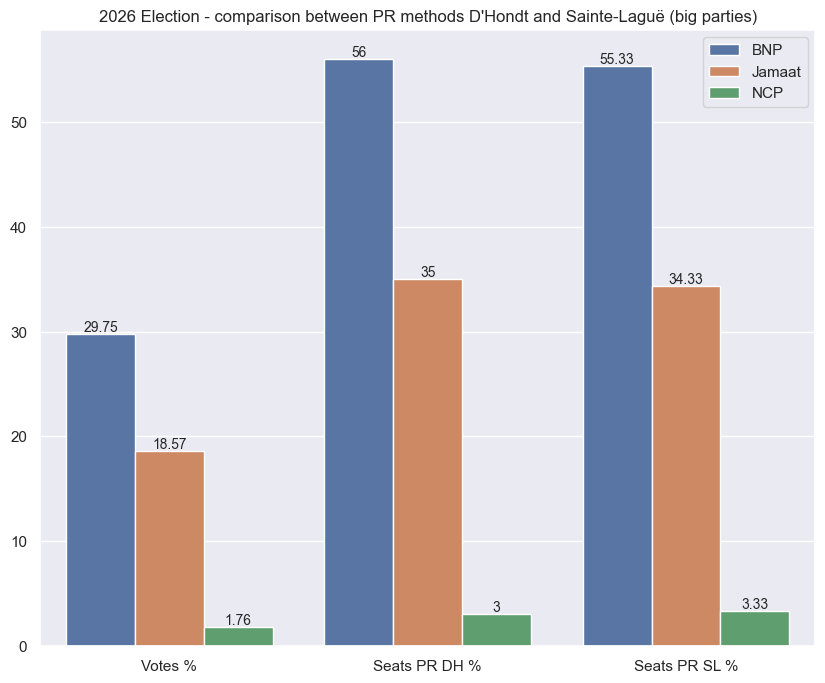

In [33]:
# melt the data for plotting big parties
vcols = ['votes_pc', 'seats_pr_dh_pc', 'seats_pr_sl_pc']
melted = pd.melt(
    df_winner_big.rename(columns={'seats_pr_pc': 'seats_pr_dh_pc'}), 
    id_vars='party', 
    value_vars=vcols
)

# plot PR method comparison for big parties
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=melted, x='variable', y='value', hue='party', ax=ax)

# set xtick labels
ax.set_xticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)

# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)


plt.title(f'{year} Election - comparison between PR methods D\'Hondt and Sainte-Laguë (big parties)')
plt.show()
fig.savefig(f'fig/method_pr_big_{year}',bbox_inches='tight')

C:\Users\muhal\AppData\Local\Temp\ipykernel_960\298446987.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(change_method_labels(vcols))


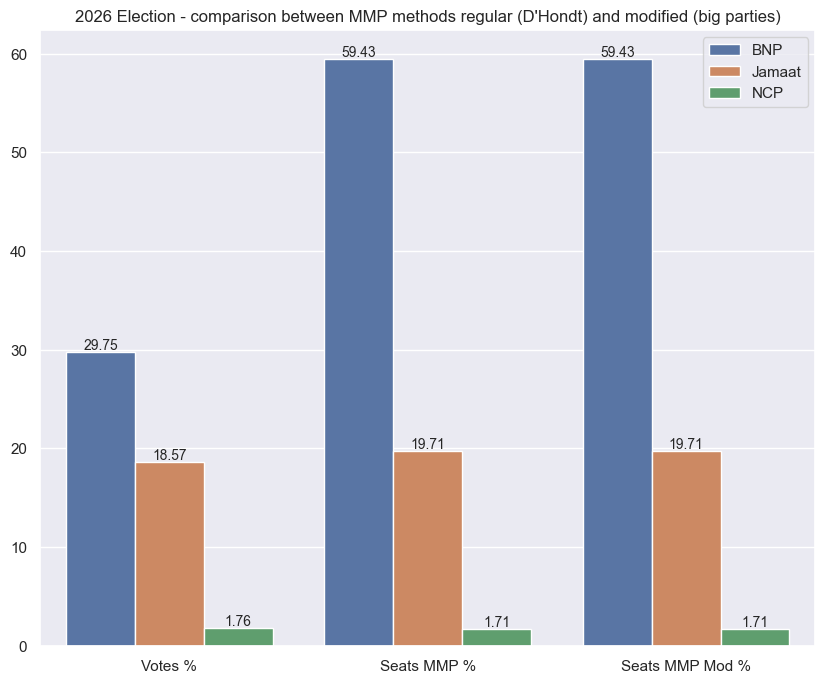

In [34]:
# melt the data for plotting big parties
vcols=['votes_pc', 'seats_mmp_pc', 'seats_mmp_mod_pc']
melted = pd.melt(
    df_winner_big, 
    id_vars='party', 
    value_vars=vcols
)

# plot MMP method comparison for big parties
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=melted, x='variable', y='value', hue='party', ax=ax)

# set xtick labels
ax.set_xticklabels(change_method_labels(vcols))
ax.set(xlabel="", ylabel="")

# add bar label
for cont in ax.containers:
    ax.bar_label(cont, fontsize=10)

# modify labels
plt.legend(loc='upper right')
handles, old_labels = ax.get_legend_handles_labels()
new_labels = change_party_labels(old_labels)
ax.legend(handles=handles, labels=new_labels)


plt.title(f'{year} Election - comparison between MMP methods regular (D\'Hondt) and modified (big parties)')
plt.show()
fig.savefig(f'fig/method_mmp_big_{year}',bbox_inches='tight')